In [1]:
!pip3 install -r requirements.txt

In [2]:
import sys
!{sys.executable} -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import spacy
from collections import Counter


In [4]:
warnings.filterwarnings("ignore")

In [5]:
#tags that were not considered mood
notmoods = ['acoustic', 'adrenaline', 'atmosphere', 'ballroom', 
            'beat', 'bizarre', 'brit pop', 'catchy', 'chic', 
            'city', 'club', 'country rock', 'countryside', 'dance pop',
           'desolation', 'disco 70', 'electronic', 'fast', 'folk contemporaneo',
           'funk', 'funk rock', 'gentle', 'glamour', 'groove', 'hard rock', 'hip-hop',
           'holiday', 'melodic', 'movement', 'new wave', 'night', 'noise', 'psychic',
           'punk', 'r&b', 'rap', 'reggae', 'remembrance', 'repetitive', 'rhythm and blues', 
            'rock & roll', 'rock blues', 'rock pop', 'slow', 'smooth', 'soft', 'soft pop',
           'soul', 'space', 'suggestive', 'summertime', 'traditional blues', 'travel', 'vintage']

In [6]:
labels = pd.read_csv('./data/tag_list.csv')

labels.columns = ['Labels']
labels_list = labels['Labels'].value_counts().keys().to_list()

In [7]:
moods = set(labels_list) - set(notmoods)

In [8]:
moods = list(moods)

In [9]:
sim_scores = np.zeros((40, 40))

In [10]:
nlp = spacy.load('en_core_web_lg')

In [11]:
#evaluate the similarty scores
for i in range(len(moods)):
    for j in range(len(moods)):
        token1 = nlp(moods[i])[0]
        token2 = nlp(moods[j])[0]
        score = token1.similarity(token2)
        sim_scores[i][j] = score

In [12]:
sim_df = pd.DataFrame(sim_scores, index=[i for i in moods])
sim_df.columns = moods

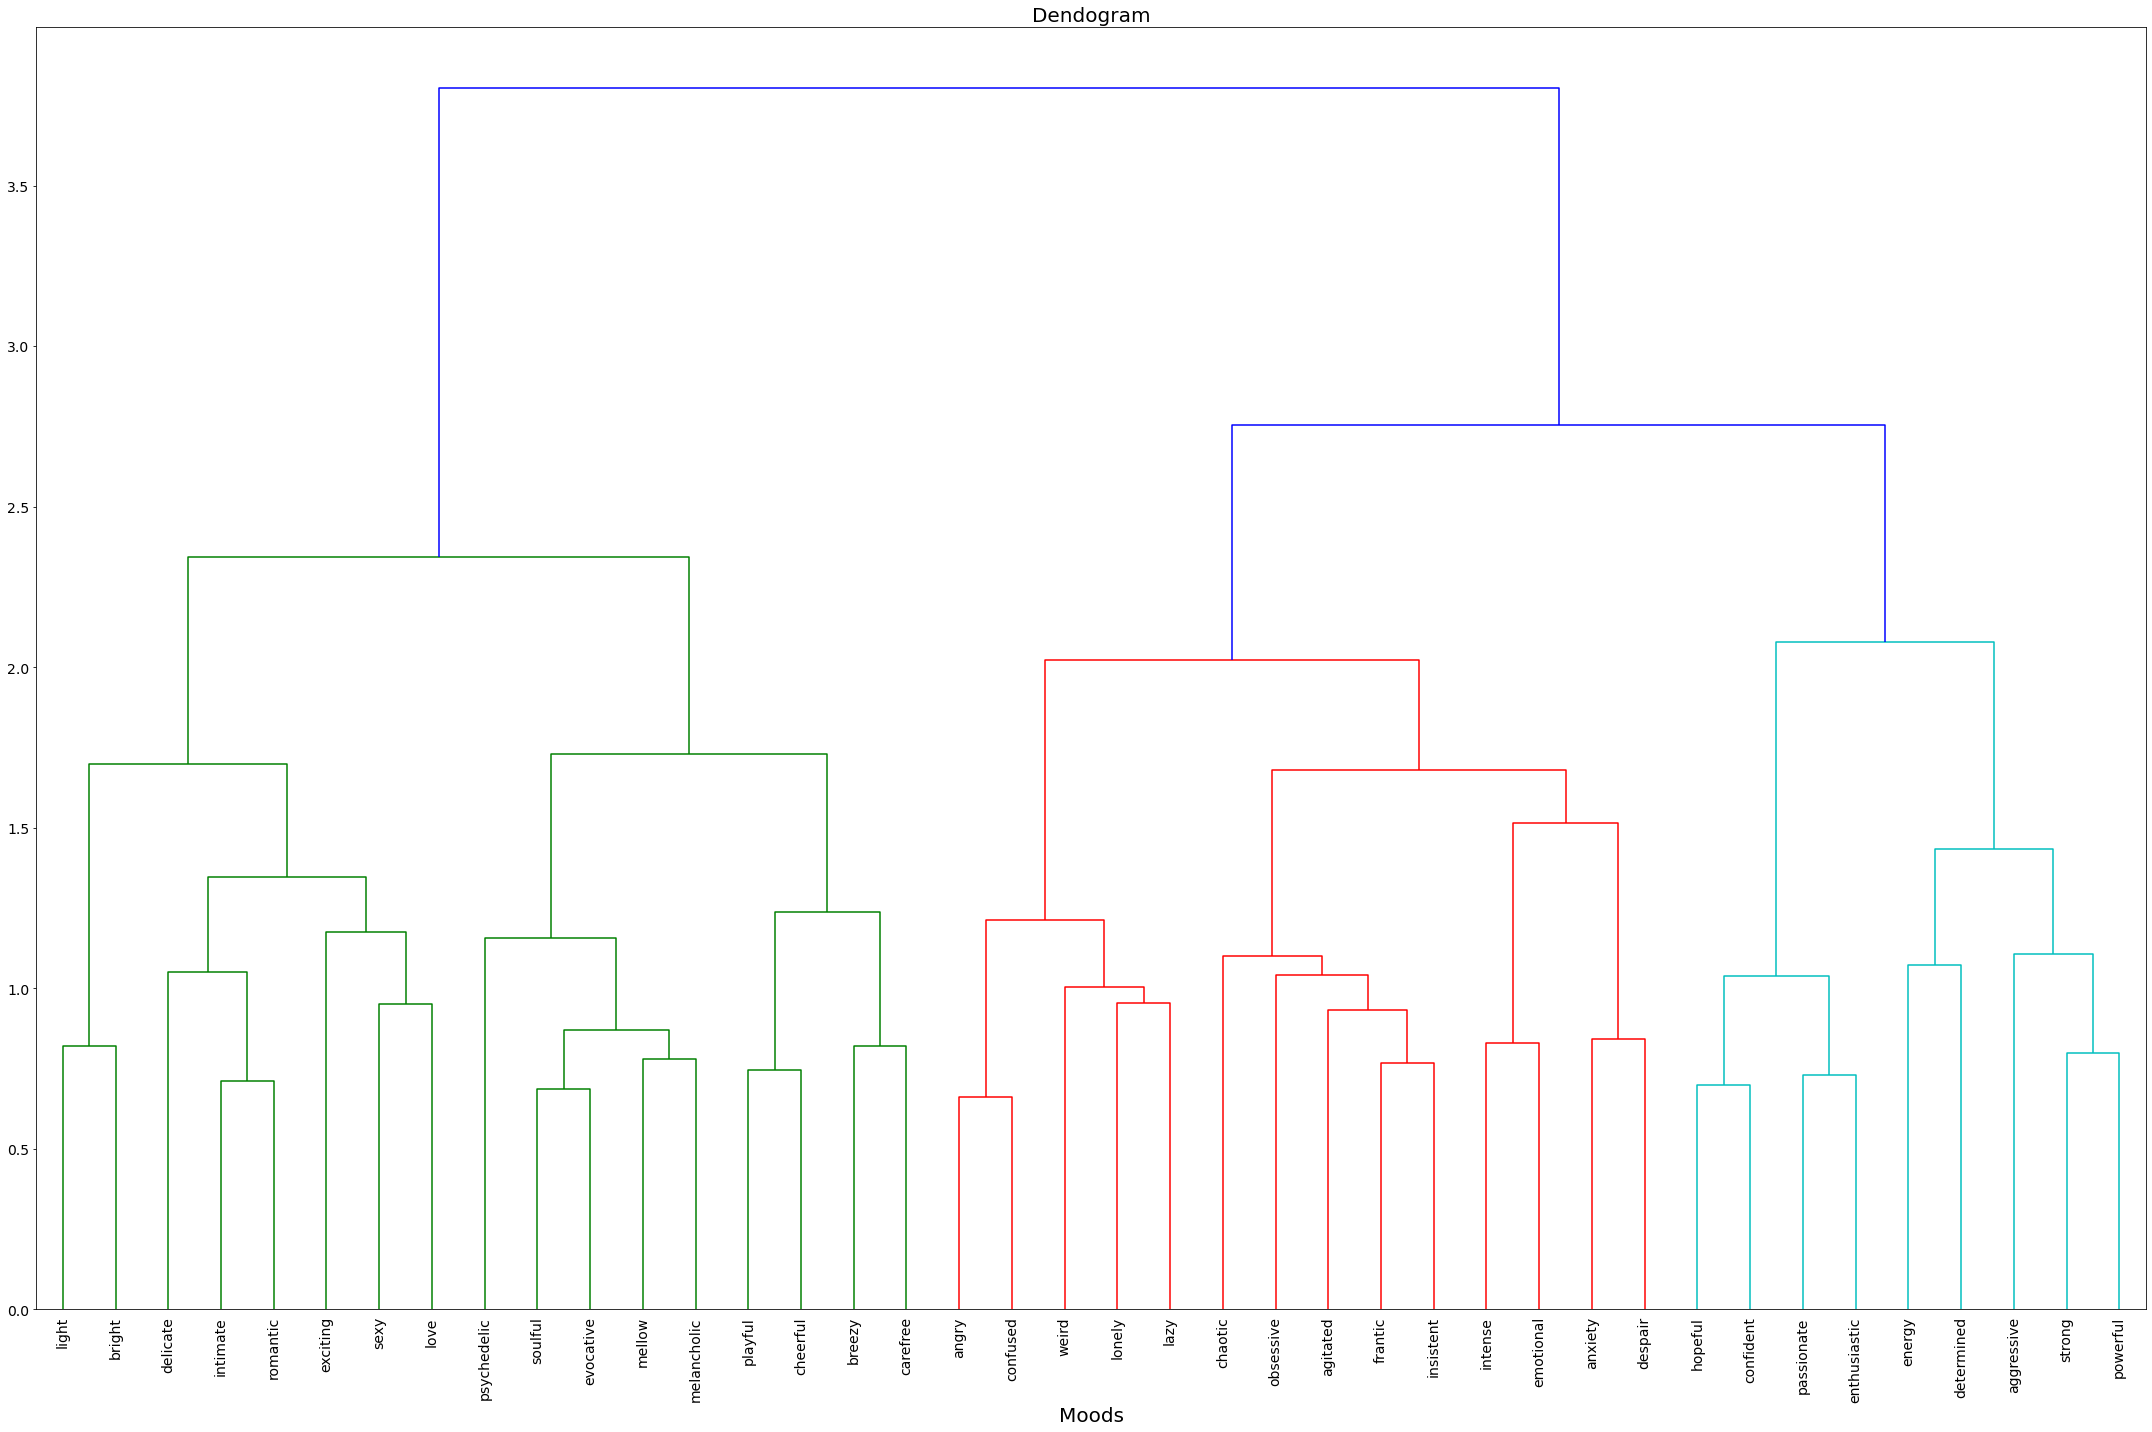

In [13]:
#hierarchical clustering using ward linkage
plt.figure(figsize=(30, 20))
linkage_matrix = linkage(sim_df, "ward")
dendrogram(linkage_matrix, labels=moods)
plt.title("Dendogram", fontsize=20)
plt.xticks(fontsize=14, rotation='vertical')
plt.yticks(fontsize=14)
plt.xlabel("Moods", fontsize=20)

plt.tight_layout()
#plt.savefig('cluster_to_see_moods_WARD.png')
plt.show()

--------

## Train Set Label Processing

In [14]:
songs_and_tags_train = pd.read_csv('./data/train.csv', sep='\t')
songs_and_tags_train.columns = ['SONG_ID', 'TAG']

In [15]:
songs_and_tags_train = songs_and_tags_train[~songs_and_tags_train.TAG.isin(notmoods)]
songs_and_tags_train.columns = ['SONG_ID', 'MOODS']

In [16]:
#grouping the tags
bright = ['bright', 'light', 'exciting']
love = ['delicate', 'intimate', 'romantic', 'love', 'sexy']
relaxed = ['psychedelic', 'evocative', 'soulful', 'melancholic', 'mellow', 'lazy']
happy = ['cheerful', 'playful', 'breezy', 'carefree']
n_strong = ['angry', 'chaotic', 'obsessive', 'emotional', 'insistent', 'agitated', 'intense']
n_down = ['confused', 'lonely', 'anxiety', 'despair', 'frantic']
optimistic = ['confident', 'hopeful', 'enthusiastic', 'passionate']
headstrong = ['determined', 'energy', 'aggressive', 'powerful', 'strong']
weird = ['weird']

In [17]:
def assign_key(x):
    if x in bright:
        return 'bright'
    if x in love:
        return 'love'
    if x in relaxed:
        return 'relaxed'
    if x in happy:
        return 'happy'
    if x in n_strong:
        return 'n_strong'
    if x in n_down:
        return 'n_down'
    if x in optimistic:
        return 'optimistic'
    if x in headstrong:
        return 'headstrong'
    if x in weird:
        return 'weird'

In [18]:
songs_and_tags_train['NEW_MOODS'] = songs_and_tags_train['MOODS'].apply(lambda x : assign_key(x))

In [19]:
mood_song_tags = songs_and_tags_train.groupby('SONG_ID')['NEW_MOODS'].apply(list).reset_index(name='MOOD_LIST')

In [20]:
def count_labels(lst):
    ct = Counter(lst)
    max_value = max(ct.values())
    return sorted(key for key, value in ct.items() if value == max_value)

In [21]:
counts = {}
moods_all_list = []
for i in range(len(mood_song_tags)):  #get the majority counts
    lst = mood_song_tags['MOOD_LIST'][i]
    counts[mood_song_tags['SONG_ID'][i]] = count_labels(lst)
    moods_all_list.append(count_labels(lst)) #add all the tags with majority counts

In [22]:
list(counts.values())[0]

['happy', 'optimistic', 'weird']

In [23]:
#create priority because we have more than one label for a song 
#n_strong>n_down>happy>love>optimistic>relaxed>headstrong>weird>bright
counts_values = list(counts.values()) 
for i in range(len(counts)):
    if len(counts_values[i]) > 1: #if there is more than one majority then priority is applied
        if 'n_strong' in counts_values[i]:
            counts_values[i] = ['n_strong']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'n_down' in counts_values[i]:
            counts_values[i] = ['n_down']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'happy' in counts_values[i]:
            counts_values[i] = ['happy']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'love' in counts_values[i]:
            counts_values[i] = ['love']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'optimistic' in counts_values[i]:
            counts_values[i] = ['optimistic']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'relaxed' in counts_values[i]:
            counts_values[i] = ['relaxed']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'headstrong' in counts_values[i]:
            counts_values[i] = ['headstrong']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'weird' in counts_values[i]:
            counts_values[i] = ['weird']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]

In [24]:
training_set = pd.DataFrame(counts.items(), columns=['SONG_ID', 'MOOD'])
training_set['MOODS'] = np.nan

In [25]:
label = []
for i in range(len(training_set)):
    label = training_set['MOOD'][i]
    training_set['MOODS'][i] = ''.join(str(x) for x in label) 

In [26]:
training_set = training_set.drop(['MOOD'], axis=1)

In [27]:
training_set.to_csv('./data/moods_train.csv', index=False)

## Test Set Label Processing

In [28]:
songs_and_tags_test = pd.read_csv('./data/test_with_groundtruth.csv', sep='\t')
songs_and_tags_test.columns = ['SONG_ID', 'TAG']

In [29]:
songs_and_tags_test = songs_and_tags_test[~songs_and_tags_test.TAG.isin(notmoods)]
songs_and_tags_test.columns = ['SONG_ID', 'MOODS']

In [30]:
songs_and_tags_test['NEW_MOODS'] = songs_and_tags_test['MOODS'].apply(lambda x : assign_key(x))

In [31]:
mood_song_tags = songs_and_tags_test.groupby('SONG_ID')['NEW_MOODS'].apply(list).reset_index(name='MOOD_LIST')

In [32]:
counts = {}
moods_all_list = []
for i in range(len(mood_song_tags)): #get the majority counts
    lst = mood_song_tags['MOOD_LIST'][i]
    counts[mood_song_tags['SONG_ID'][i]] = count_labels(lst)
    moods_all_list.append(count_labels(lst)) #add all the tags with majority counts

In [33]:
#priority n_strong>n_down>happy>love>optimistic>relaxed>headstrong>weird>bright
counts_values = list(counts.values())
for i in range(len(counts)):
    if len(counts_values[i]) > 1: #if there is more than one majority then priority is applied
        if 'n_strong' in counts_values[i]:
            counts_values[i] = ['n_strong']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'n_down' in counts_values[i]:
            counts_values[i] = ['n_down']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'happy' in counts_values[i]:
            counts_values[i] = ['happy']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'love' in counts_values[i]:
            counts_values[i] = ['love']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'optimistic' in counts_values[i]:
            counts_values[i] = ['optimistic']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'relaxed' in counts_values[i]:
            counts_values[i] = ['relaxed']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'headstrong' in counts_values[i]:
            counts_values[i] = ['headstrong']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]
        elif 'weird' in counts_values[i]:
            counts_values[i] = ['weird']
            counts[mood_song_tags['SONG_ID'][i]] = counts_values[i]

In [34]:
testing_set = pd.DataFrame(counts.items(), columns=['SONG_ID', 'MOOD'])
testing_set['MOODS'] = np.nan

In [35]:
label = []
for i in range(len(testing_set)):
    label = testing_set['MOOD'][i]
    testing_set['MOODS'][i] = ''.join(str(x) for x in label) 

In [36]:
testing_set = testing_set.drop(['MOOD'], axis=1)

In [37]:
testing_set.to_csv('./data/moods_test.csv', index=False)